In [1]:
import tensorflow as tf
import mitdeeplearning as mdl
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sc
import pandas as pd
dataFile = "./communication/my_data.mat"
sambolsFile = './communication/mysambol.mat'
labelFile = './communication/my_labels.mat'
my_data = sc.loadmat(dataFile)
my_labels = sc.loadmat(labelFile)
data2 = sc.loadmat(sambolsFile)
my_data = my_data['Y']
I = data2['I']
N = data2['N']
X = my_labels['L_S_x']

In [147]:
'''
def table_data(my_data, snr, inr, cons, label):
    block = my_data.shape[1]
    my_data_size = my_data.shape[0] * block
    my_data_div = my_data.T.reshape(my_data_size,)
    snr_array = np.array([snr]*my_data_size)
    inr_array = np.array([inr]*my_data_size)
    cons_array = np.array([[cons[i]]*my_data.shape[0] for i in range(0,block)]).reshape(my_data_size,)
    block_array = np.array([([i+1]*my_data.shape[0])for i in range(0, block)]).reshape(my_data_size,)
    label_array = label.T.reshape(my_data_size,)
    test_pd = pd.DataFrame({'real':my_data_div.real,'imag':my_data_div.imag, 'snr':snr_array, 'inr':inr_array,
            'cons':cons_array, 'block':block_array, 
            'lreal':label_array.real, 'limag':label_array.imag})
    return test_pd
myTable = table_data(my_data, 0.6, 0.05, my_labels['L_Constellations'][0], X)
'''

"\ndef table_data(my_data, snr, inr, cons, label):\n    block = my_data.shape[1]\n    my_data_size = my_data.shape[0] * block\n    my_data_div = my_data.T.reshape(my_data_size,)\n    snr_array = np.array([snr]*my_data_size)\n    inr_array = np.array([inr]*my_data_size)\n    cons_array = np.array([[cons[i]]*my_data.shape[0] for i in range(0,block)]).reshape(my_data_size,)\n    block_array = np.array([([i+1]*my_data.shape[0])for i in range(0, block)]).reshape(my_data_size,)\n    label_array = label.T.reshape(my_data_size,)\n    test_pd = pd.DataFrame({'real':my_data_div.real,'imag':my_data_div.imag, 'snr':snr_array, 'inr':inr_array,\n            'cons':cons_array, 'block':block_array, \n            'lreal':label_array.real, 'limag':label_array.imag})\n    return test_pd\nmyTable = table_data(my_data, 0.6, 0.05, my_labels['L_Constellations'][0], X)\n"

In [2]:
def table_data(my_data, cons, label):
    block = my_data.shape[1]
    my_data_size = my_data.shape[0] * block
    my_data_div = my_data.T.reshape(my_data_size,)
    cons_array = np.array([[cons[i]]*my_data.shape[0] for i in range(0,block)]).reshape(my_data_size,)
    block_array = np.array([([i+1]*my_data.shape[0])for i in range(0, block)]).reshape(my_data_size,)
    label_array = label.T.reshape(my_data_size,)
    test_pd = pd.DataFrame({'real':my_data_div.real,'imag':my_data_div.imag,
            'cons':cons_array, 'block':block_array, 
            'label':label_array})
    return test_pd
myOrig = table_data(my_data, my_labels['L_Constellations'][0], X)

In [3]:
def assign_labels(myTable):
    myTest = myTable.copy()
    myTest.loc[myTest.cons==2, 'label'] = myTest.loc[myTest.cons==2, 'label']+4
    myTest.label = myTest.label-1
    return myTest
myTable = assign_labels(myOrig)


In [7]:
myTable = myTable.append({'final':123}, ignore_index=True)
myTable

,real,imag,cons,block,label,final
0,60.068213,-22.219052,2.0,1.0,15.0,NaN
1,14.209541,-53.564195,2.0,1.0,18.0,NaN
2,53.640412,52.947667,2.0,1.0,7.0,NaN
3,22.620277,60.863937,2.0,1.0,6.0,NaN
4,52.958485,53.843684,2.0,1.0,7.0,NaN
...,...,...,...,...,...,...
49997,14.257863,-16.236603,2.0,1000.0,14.0,NaN
49998,-15.398305,-21.573138,2.0,1000.0,13.0,NaN
49999,22.886454,59.821479,2.0,1000.0,6.0,NaN
50000,NaN,NaN,NaN,NaN,NaN,123.0


In [150]:
from numpy.random import default_rng
def training_set(myTable):
    block = myTable.shape[0]
    rng = default_rng()
    sample_size = int(0.8 * block)
    print(sample_size)
    numbers = rng.choice(range(1, block + 1), size=sample_size, replace=False)
    training_dataset = myTable[myTable.block.isin(numbers)]
    return training_dataset


def test_set(myTable, training_dataset):
    remaining = myTable.drop(training_dataset.index)
    return remaining

In [151]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [152]:
'set training sample'
train_dataset = training_set(myTable)
test_dataset = test_set(myTable, train_dataset)

40000


In [153]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = pd.DataFrame([train_features.pop('label')]).T
test_labels = pd.DataFrame([test_features.pop('label')]).T

In [154]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[ 3.8610768e-01 -2.7741802e-01  1.4826303e+00  5.0422830e+02]


In [155]:
train_labels.shape

(40300, 1)

In [156]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(50, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(20)
    ])
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(0.01),
                 metrics=['accuracy'])
    return model

In [157]:
dnn_real_model = build_and_compile_model(normalizer)

In [158]:
history = dnn_real_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

In [159]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Ireal]')
    plt.legend()
    plt.grid(True)

In [160]:
test_results = {}
test_results['result'] = dnn_real_model.evaluate(
    test_features,
    test_labels, verbose=0)

In [161]:
y1 = dnn_real_model.predict(test_features)

In [162]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,0.0,1.0,0.0,1.0,95
96,0.0,1.0,0.0,1.0,96
97,0.0,1.0,0.0,1.0,97
98,0.0,1.0,0.0,1.0,98
99,0.0,1.0,0.0,1.0,99


In [163]:
def plot_image(predict_label, true_label):
    i = 0
    while i < len(predict_label):
        predict_data = predict_label[i]
        true_label = test_labels.to_numpy()[i]
        plot_image(predict_data, true_label)
        predicted_label = np.argmax(predict_data[i])
        data = construct_data(predicted_label)
        i = i + 1
        if predicted_label[i] == true_label[i]:
            plt.plot(data.real, data.imag, 'o', color='blue')
        else:
            color = 'black'
            plt.plot(data.real-0.1, data.imag-0.1, 'o', color='red')
        print(y)
        

In [167]:
def get_total_loss(predict_label, true_label):
    i = 0
    for j in range(len(predict_label)):
        prediction = np.argmax(predict_label[j])
        if prediction != true_label[j]:
            i = i + 1
    return i

In [98]:
def construct_data(label):
    constellation4 = np.dot(np.sqrt(0.5),[1+1j, 1-1j, -1+1j, -1-1j])
    constellation16 = np.array([-3+3j, -1+3j, 1+3j, 3+3j,
                              -3+1j, -1+1j, 1+1j, 3+1j,
                              -3-1j, -1-1j, 1-1j, 3-1j,
                              -3-3j, -1-3j, 1-3j, 3-3j])
    constellation16 =constellation16/np.sqrt(np.mean(np.abs(constellation16)**2))
    constellation = np.hstack([constellation4,constellation16])
    test_label = label.copy()
    test_label = np.array([constellation[i]+1for i in test_labels.to_numpy()])
    return test_label

In [169]:
get_total_loss(y1, test_labels.to_numpy())

0

In [171]:
y1[(0)]

array([ -34.09646 ,  -57.997627,   25.977114,  -10.006982,  -22.03362 ,
       -112.668564, -115.73107 , -120.33631 ,  -49.06224 ,  -96.07154 ,
       -218.59058 , -102.71806 ,  -93.47305 , -102.10301 , -139.73123 ,
        -89.137115,  -90.88934 , -123.60283 ,  -94.32052 ,  -39.198524],
      dtype=float32)

In [41]:
def total_loss(predict_label, true_label):
    i = 0
    for j in range(len(predict_label)):
        if predict_label[j] != true_label[j]:
            i = i + 1
    return i

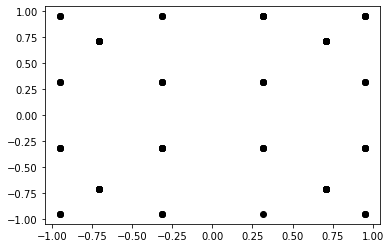

In [206]:

def plot_image(i, predictions_array, true_label, img):
    tru true_label.real, true_label.imag
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
            color = 'blue'
    else:
            color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

In [278]:
imag_features = train_features.loc[:,['imag','snr', 'inr', 'cons']]
imag_normalizer = preprocessing.Normalization()
imag_normalizer.adapt(np.array(train_features.loc[:,['imag','snr', 'inr', 'cons']]))
print(imag_features)

          imag  snr   inr  cons
0   -53.722042  0.6  0.05     2
1   -61.907205  0.6  0.05     2
2    15.121133  0.6  0.05     2
3    21.412338  0.6  0.05     2
4   -14.780646  0.6  0.05     2
..         ...  ...   ...   ...
175  60.629573  0.6  0.05     2
176 -60.540215  0.6  0.05     2
177 -16.349881  0.6  0.05     2
178 -22.468496  0.6  0.05     2
179  60.088177  0.6  0.05     2

[150 rows x 4 columns]


In [279]:
dnn_imag_model = build_and_compile_model(imag_normalizer)

In [282]:
imag_features = train_features.loc[:,['imag','snr', 'inr', 'cons']]

In [283]:
result2 = dnn_imag_model.fit(
    imag_features, train_labels_imag,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [284]:
test1_results = {}
test1_results['imag_model'] = dnn_real_model.evaluate(
    test_features.loc[:,['imag','snr', 'inr', 'cons']],
    test_labels_imag, verbose=0)

In [285]:
y2 = dnn_imag_model.predict(test_features.loc[:,['imag','snr', 'inr', 'cons']]).flatten()

In [286]:
def plot_real(y1, y2):
    plt.scatter(test_labels_real, test_labels_imag, color='black',label='Data')
    plt.plot(y1, y2,  'o', color='red', label='Predictions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

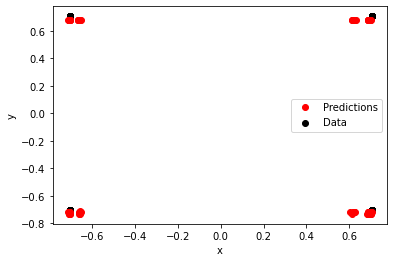

In [287]:
plot_real(y1,y2)

In [309]:
def get_loss(lreal, limag, y1, y2):
    total_loss = 0
    real_array = lreal.to_numpy()
    imag_array = limag.to_numpy()
    for i in range(0,len(lreal)):
        total_loss = (real_array[i] - y1[i])**2 + (imag_array[i] - y2[i])**2
    mean_loss = total_loss/len(lreal)
    return mean_loss